In [40]:
%matplotlib inline
#%matplotlib notebook

In [41]:
import cytoflow as flow
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import scipy.stats as stats
import scipy as sp
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import numpy as np
from numpy import median
matplotlib.rc('figure', dpi = 160)

# Import samples and specify experimental condtions

sets the conditions of the tube

In [43]:
inputs = [
    ["20210512_Tube_001_001.fcs",0,0,'WT'],
    #["20210512_Tube_046_046.fcs",1e-8,0.5,'LuxR'],
    #["20210512_Tube_047_048.fcs",1e-9,0.5,'LuxR'],
    #["20210512_Tube_048_050.fcs",1e-10,0.5,'LuxR'],
    ["20210512_Tube_048_051.fcs",1e-10,0.5,'used'],
    ["20210512_Tube_046_047.fcs",1e-8,0.5,'used'],
    ["20210512_Tube_047_049.fcs",1e-9,0.5,'used'],
]

       
tubes = []
for filename, ahl, iptg, family in inputs:
    tubes.append(flow.Tube(file = 'data/' + filename, conditions = {'AHL' : ahl, 'IPTG' : iptg, 'Family' : family}))
    
ex = flow.ImportOp(conditions = {'AHL' : 'float', 'IPTG' : 'float', 'Family' : 'str'},
                   tubes = tubes).apply()
       


In [44]:
flow.set_default_scale("log")

# Plot FITC-A histograms for all IPTG and AHL induction conditions

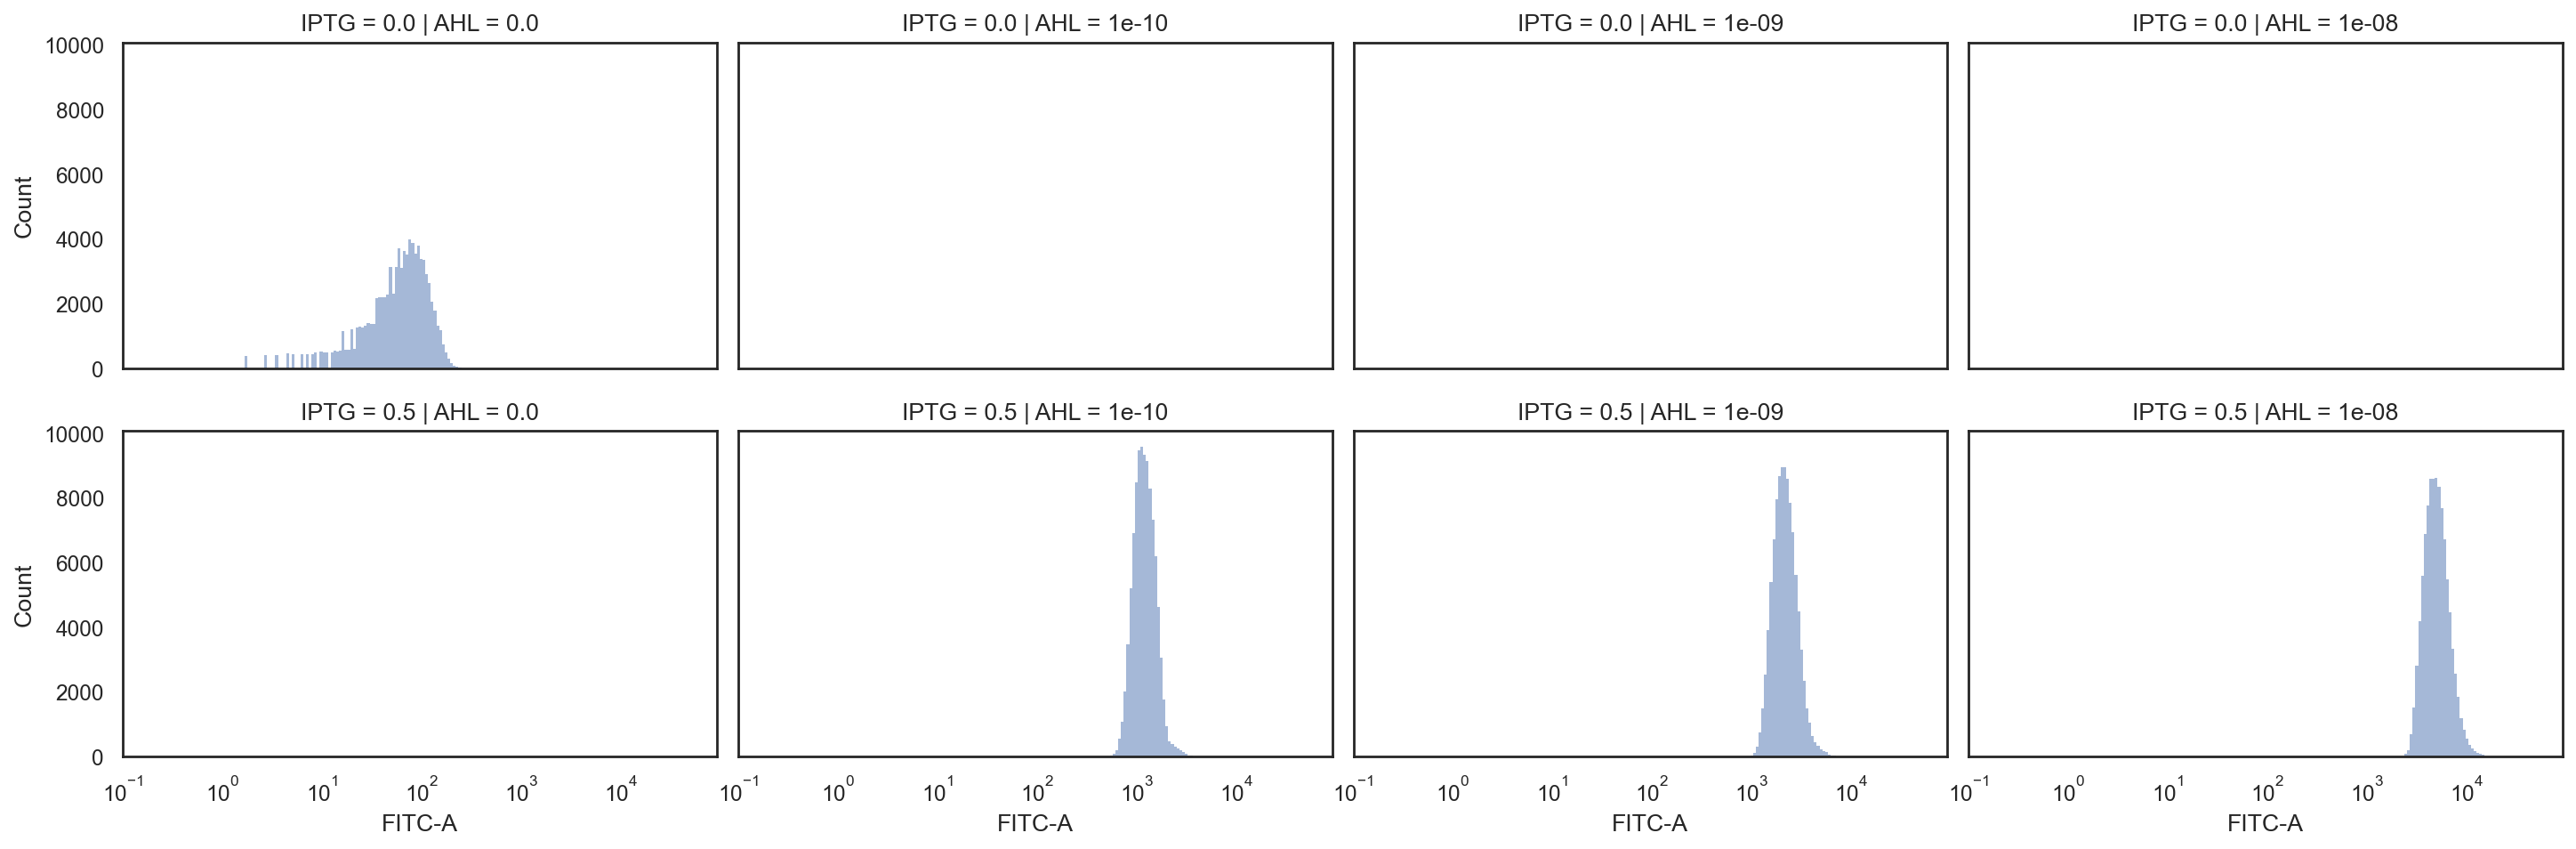

In [45]:
flow.HistogramView(channel = "FITC-A",
                   xfacet = "AHL",
                  yfacet = 'IPTG').plot(ex)

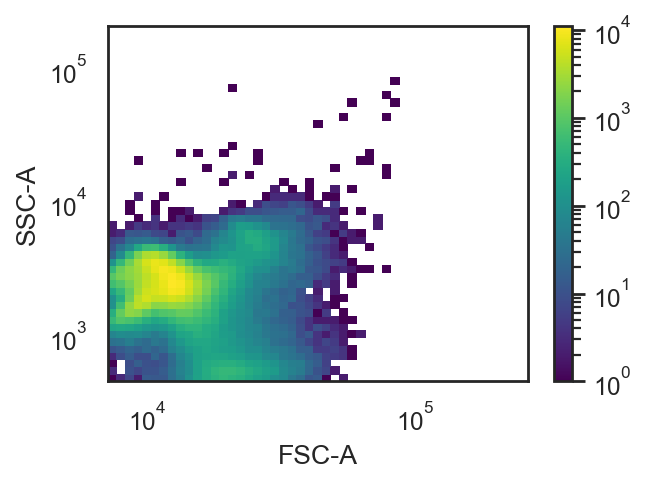

In [46]:
flow.DensityView(xchannel = "FSC-A", 
                 ychannel = "SSC-A",
                 xscale = 'log',
                 yscale = 'log').plot(ex, min_quantile = 0.005)

# Singlet gating to remove doublets

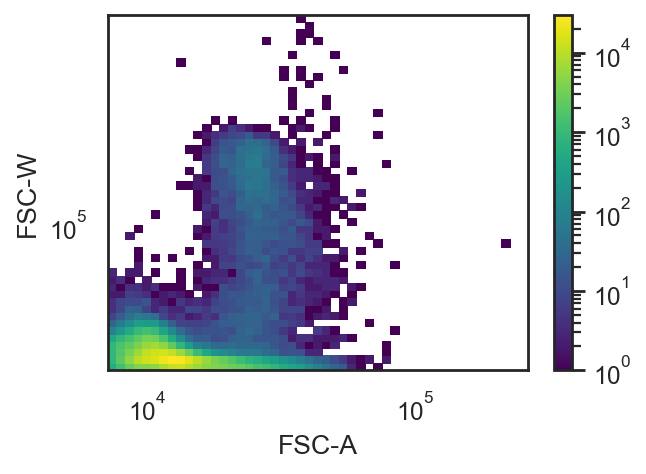

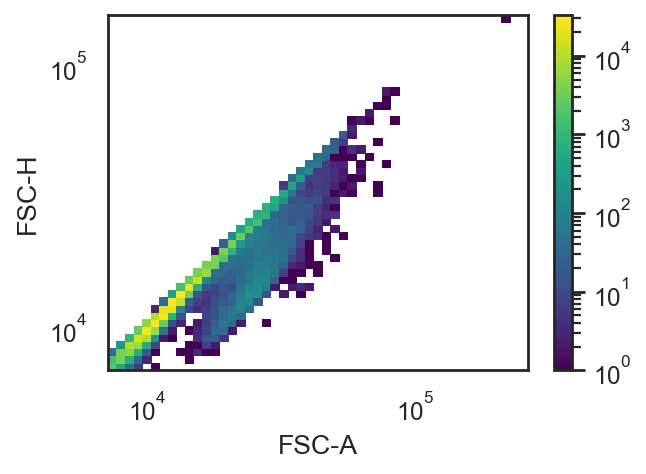

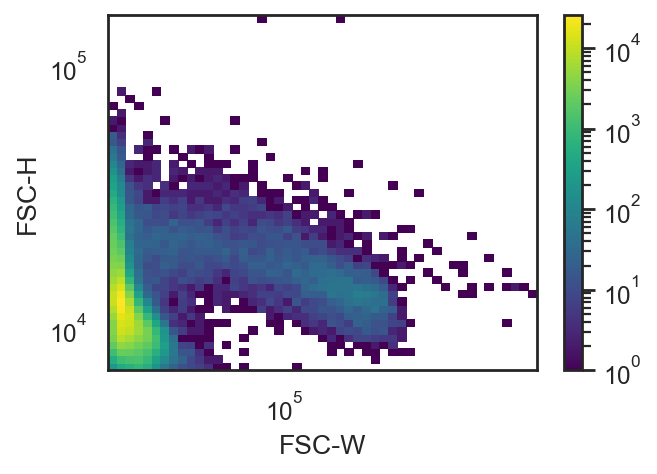

In [47]:

#channels = ['FSC-A','FSC-W','FSC-H','SSC-A','SSC-W','SSC-H']
#perm = combinations(channels,2)
FSC = [('FSC-A','FSC-W'),('FSC-A','FSC-H'),('FSC-W','FSC-H')]

#f, axes = plt.subplots(ncols=4,nrows=4)
#axs = axes.ravel()
for i,(x,y) in enumerate(FSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'log',
                yscale = 'log').plot(ex, min_quantile = 0.005)


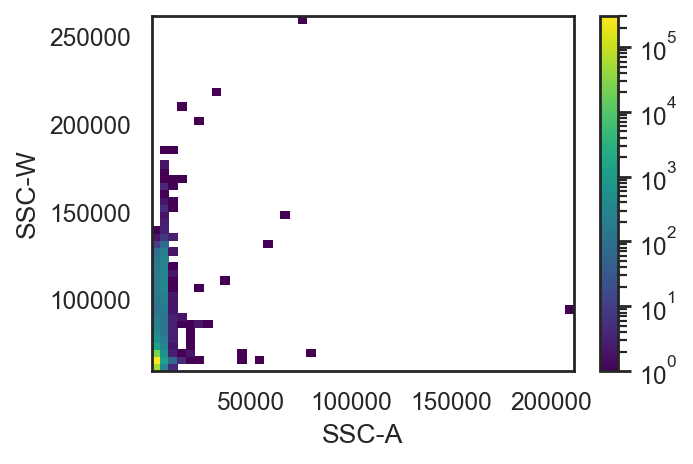

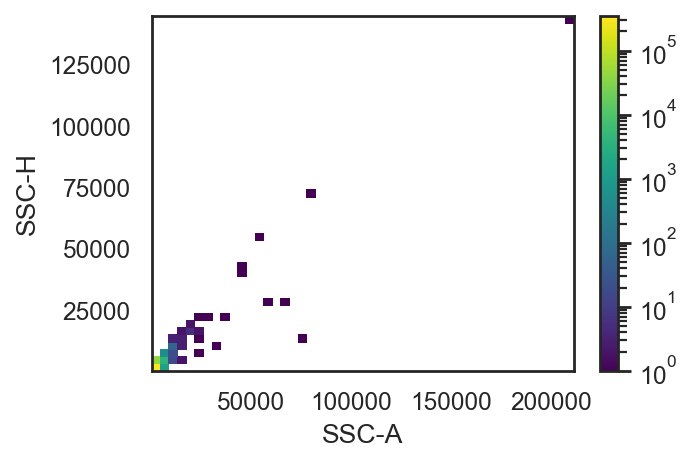

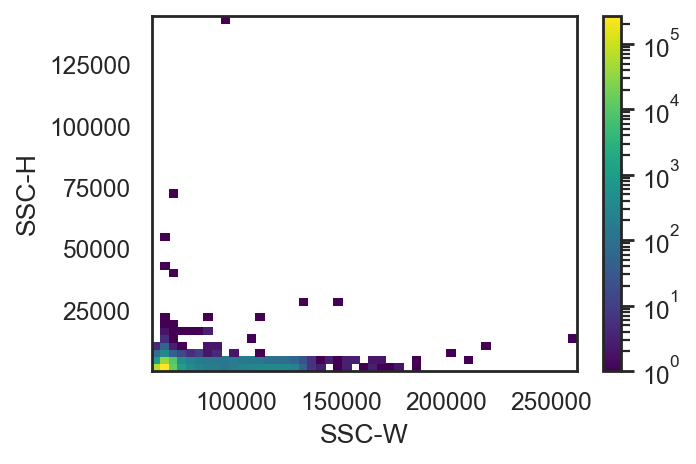

In [48]:
SSC = [('SSC-A','SSC-W'),('SSC-A','SSC-H'),('SSC-W','SSC-H')]
for i,(x,y) in enumerate(SSC):  
    flow.DensityView(xchannel = x, 
                ychannel = y,
                xscale = 'linear',
                yscale = 'linear').plot(ex, min_quantile = 0.005)

## Create and store singlet gate

saves the single data as ex2

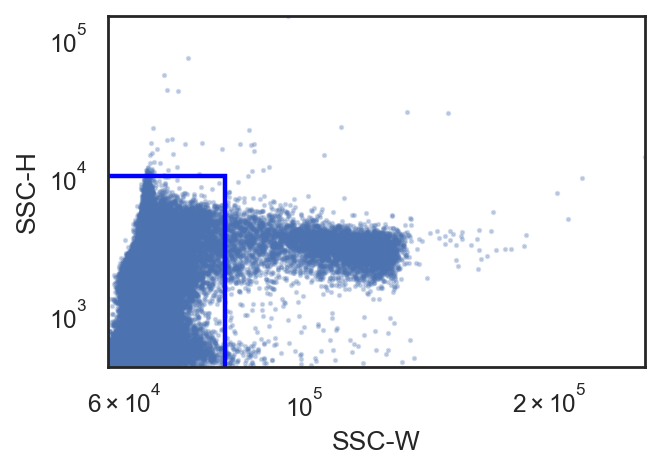

In [61]:
r = flow.Range2DOp(name = "Range2D",
                   xchannel = "SSC-W",
                   xlow = 55000,
                   xhigh = 80000,
                   ychannel = "SSC-H",
                   ylow = 100,
                   yhigh = 10000)
                   
rv = r.default_view(xscale ='log',yscale='log')

rv.plot(ex)
ex2 = r.apply(ex)

## Use a gaussian mixture model to further gate the population

/opt/anaconda3/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'GM_1'


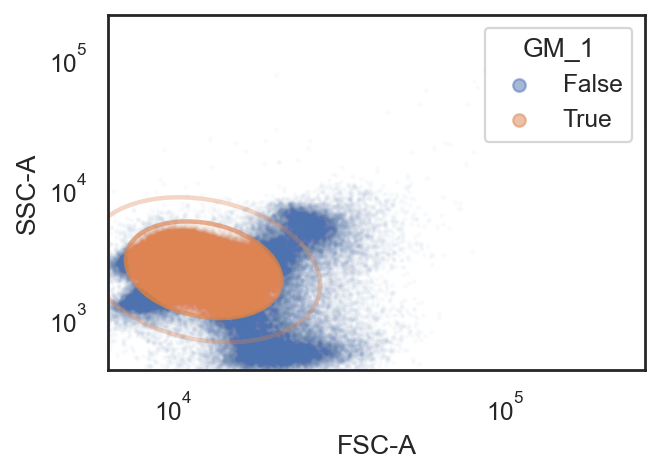

In [62]:
gm = flow.GaussianMixtureOp(name = "GM",
                            channels = ['FSC-A', 'SSC-A'],
                            scale = {'FSC-A' : 'log',
                                     'SSC-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm.estimate(ex2)
ex_gm = gm.apply(ex2)
gm.default_view().plot(ex_gm, alpha = 0.02)

/opt/anaconda3/lib/python3.8/site-packages/cytoflow/operations/base_op_views.py:341: CytoflowViewWarning: Setting 'huefacet' to 'GM3_1'


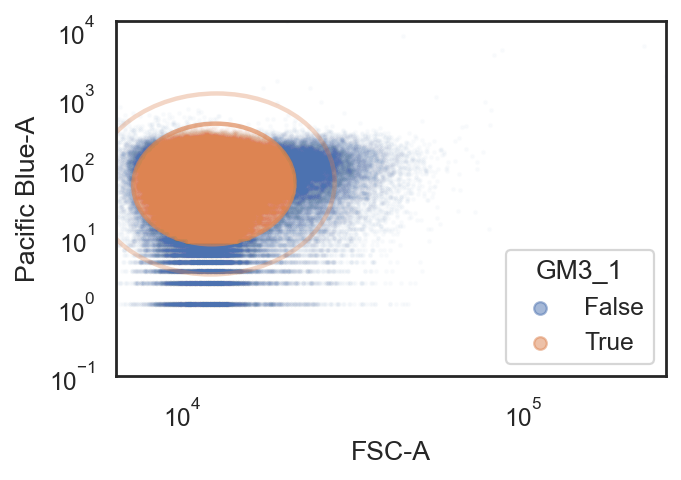

In [63]:
gm3 = flow.GaussianMixtureOp(name = "GM3",
                            channels = ['FSC-A', 'Pacific Blue-A'],
                            scale = {'FSC-A' : 'log',
                                     'Pacific Blue-A' : 'log'},
                            num_components = 1,
                            sigma = 2)
gm3.estimate(ex_gm)
ex_gm2 = gm3.apply(ex_gm)
gm3.default_view().plot(ex_gm2, alpha = 0.02)

In [64]:
df =ex_gm2.data

take the stuff from cytoflow and changing it to datatframe

# filter out events that don't fall within the gates

In [65]:

df = df[(df.GM_1==True) & (df.GM3_1==True) & (df.Range2D==True) & (df['FITC-A'] >0)]
df

,AHL,AmCyan-A,AmCyan-H,AmCyan-W,FITC-A,FITC-H,FITC-W,FSC-A,FSC-H,FSC-W,...,PerCP-Cy5-5-A,PerCP-Cy5-5-H,PerCP-Cy5-5-W,SSC-A,SSC-H,SSC-W,Time,Range2D,GM_1,GM3_1
3,0.000000e+00,105.279999,76.0,90784.601562,25.520000,76.0,22006.300781,11223.750000,10824.0,67956.367188,...,9589.360352,9096.0,69090.632812,2457.840088,2392.0,67339.890625,54.700001,True,True,True
4,0.000000e+00,26.880001,156.0,11292.357422,55.439999,60.0,60555.265625,8971.700195,8824.0,66632.968750,...,7932.319824,9224.0,56358.687500,1378.079956,1400.0,64509.894531,54.700001,True,True,True
5,0.000000e+00,11.200000,112.0,6553.599609,79.199997,64.0,81100.804688,9462.259766,9300.0,66679.437500,...,9366.719727,9908.0,61955.734375,1663.199951,1716.0,63519.507812,54.700001,True,True,True
6,0.000000e+00,141.119995,104.0,88927.312500,125.839996,88.0,93716.476562,10396.660156,10380.0,65641.187500,...,9064.000000,9084.0,65391.710938,2091.760010,2136.0,64178.648438,54.799999,True,True,True
7,0.000000e+00,275.519989,81.0,222919.484375,131.119995,65.0,132201.234375,7625.580078,7237.0,69054.851562,...,18952.560547,18565.0,66904.125000,3078.239990,2997.0,67312.492188,54.799999,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399993,1.000000e-09,199.360001,172.0,75960.796875,2053.040039,2004.0,67139.734375,11313.540039,11056.0,67062.601562,...,16034.479492,14600.0,71975.039062,2944.479980,2980.0,64754.843750,2348.699951,True,True,True
399994,1.000000e-09,311.360016,81.0,251917.156250,1411.520020,1411.0,65560.148438,12159.610352,11991.0,66457.523438,...,10967.439453,10501.0,68447.023438,1908.719971,1975.0,63336.644531,2348.800049,True,True,True
399995,1.000000e-09,-33.599998,157.0,0.000000,2202.639893,2445.0,59039.757812,11904.110352,11753.0,66378.609375,...,13924.240234,13753.0,66351.992188,2689.280029,2665.0,66133.085938,2348.800049,True,True,True
399996,1.000000e-09,246.399994,216.0,74759.585938,3743.520020,3632.0,67548.273438,10985.770508,10260.0,70171.882812,...,18717.599609,17820.0,68837.070312,4018.959961,3840.0,68590.250000,2348.800049,True,True,True


In [66]:
df.columns 



Index(['AHL', 'AmCyan-A', 'AmCyan-H', 'AmCyan-W', 'FITC-A', 'FITC-H', 'FITC-W',
       'FSC-A', 'FSC-H', 'FSC-W', 'Family', 'IPTG', 'Pacific Blue-A',
       'Pacific Blue-H', 'Pacific Blue-W', 'PerCP-Cy5-5-A', 'PerCP-Cy5-5-H',
       'PerCP-Cy5-5-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Time', 'Range2D', 'GM_1',
       'GM3_1'],
      dtype='object')

In [67]:
data = df[['FITC-A','AHL','IPTG','Family']]
#data.insert(4,'Replicate',2)
#data.to_pickle('../compiled-data/se/lux/LuxSE_2.pkl')
#uncomment these when you are ready to save replicates and compile replicate from other runs

In [68]:
# Subtract WT background from samples
data = df[['FITC-A','AHL','IPTG','Family']]
data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
data['FITC-A'] = data[data['FITC-A'] > 0]['FITC-A']
data = data[data.Family=='used']
data.drop('Family',inplace=True,axis=1)

<ipython-input-68-603c8fd03249>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-68-603c8fd03249>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
data['FITC-A'].min()

1.7600021362304688

In [70]:
data

,FITC-A,AHL,IPTG
100002,1052.479965,1.000000e-10,0.5
100004,1522.400009,1.000000e-10,0.5
100007,1053.359970,1.000000e-10,0.5
100010,1082.400009,1.000000e-10,0.5
100011,1082.400009,1.000000e-10,0.5
...,...,...,...
399993,1989.680038,1.000000e-09,0.5
399994,1348.160019,1.000000e-09,0.5
399995,2139.279892,1.000000e-09,0.5
399996,3680.160019,1.000000e-09,0.5


# Plot median FITC-A

use median or geometeric mean 

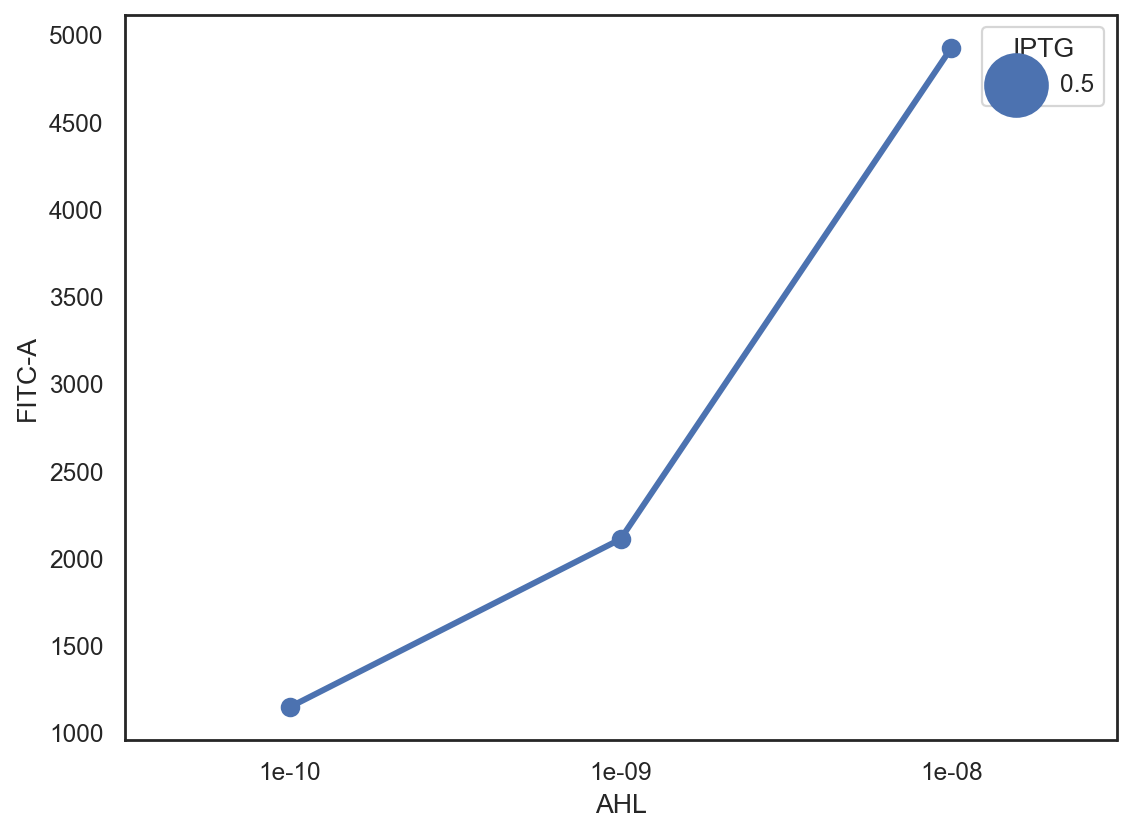

In [71]:
mfi = data.groupby(['AHL','IPTG'])['FITC-A'].median().reset_index()

f, ax = plt.subplots(figsize=(8,6))
sns.pointplot(x='AHL',y='FITC-A',hue='IPTG',data=mfi)
f.savefig('used.png',dpi=600)

# Plot heatmaps showing absolute and relative induction

Raw signal 

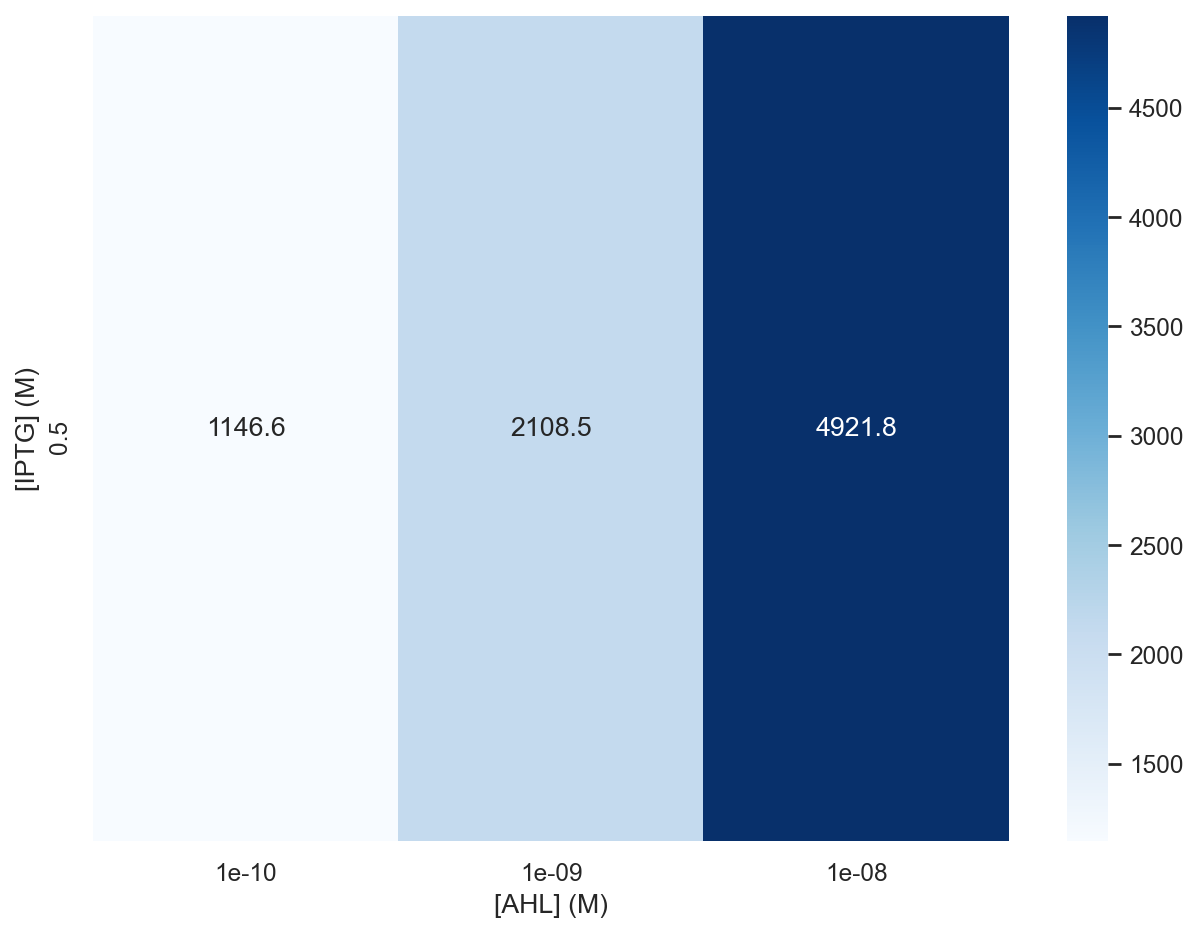

In [72]:
#LasMeans = Las.groupby(['C_ahl','C_iptg']).mean().reset_index()
sns.set(style="white")
#sns.set_style('Talk')
#LasTable = pd.pivot_table(LasMeans,values='FITC-A',index='C_iptg',columns='C_ahl')
f, ax = plt.subplots(figsize=(8,6))
#g = sns.heatmap(LasTable,vmin=0,vmax=100,xticklabels=[0,1e-10,1e-9,1e-7],yticklabels=[0,1e-3,1e-4,1e-5],ax=ax,square=True,cmap='Reds')



#f.savefig('LasHeatmap.png',dpi=600)

#mean['FITC-A']=mean['FITC-A']/mean['FITC-A'].max()*100

piv = mfi.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
#cbar.set_ticks([0, 25, 50, 75,100])
#cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

Normalized to highest signal 

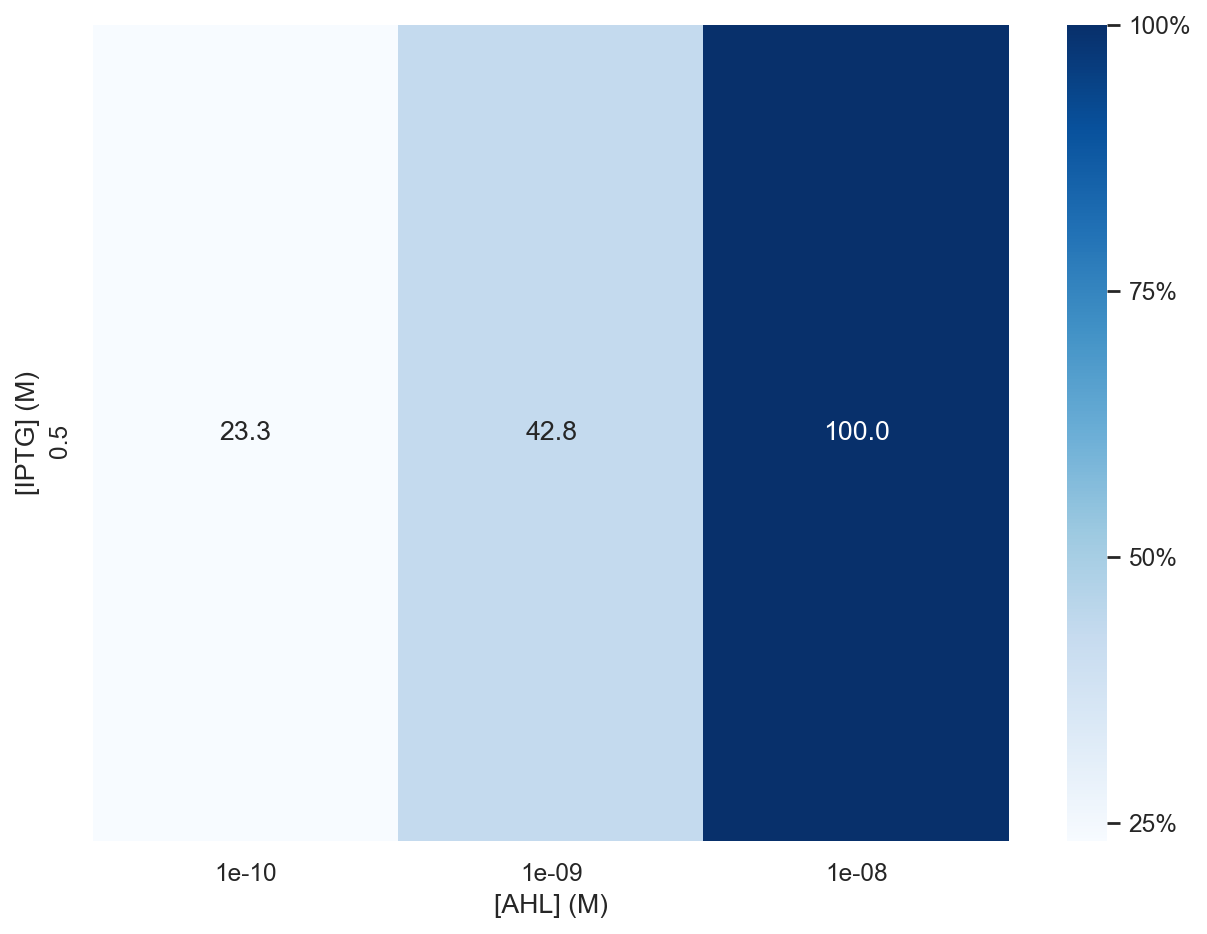

In [73]:
f, ax = plt.subplots(figsize=(8,6))
# normalized
norm = mfi.copy()
norm['FITC-A']=norm['FITC-A']/norm['FITC-A'].max()*100

piv = norm.pivot_table(index='IPTG', columns='AHL', values='FITC-A')
g = sns.heatmap(piv, annot=True, fmt=".1f",cmap='Blues')
cbar = g.collections[0].colorbar
cbar.set_ticks([0, 25, 50, 75,100])
cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
ax.set_xlabel(r'[AHL] (M)')
ax.set_ylabel(r'[IPTG] (M)')
f.tight_layout()

# Calculate the on/off ratio and plot

In [74]:

R =[]
for i in mfi.IPTG.unique():
    tmp = mfi[mfi.IPTG ==i]['FITC-A'].max()/mfi[mfi.IPTG ==i]['FITC-A'].min()
    R.append([i,tmp])



In [75]:

R = pd.DataFrame(R,columns=['IPTG','Induction Ratio'])
R

,IPTG,Induction Ratio
0,0.5,4.292402


<AxesSubplot:xlabel='IPTG', ylabel='Induction Ratio'>

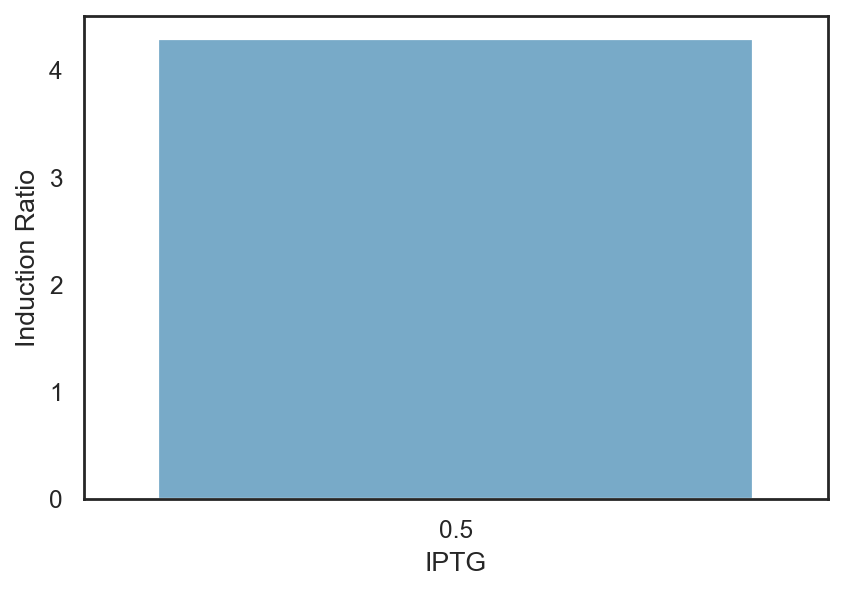

In [76]:
f, ax  = plt.subplots()
sns.barplot(x='IPTG',y='Induction Ratio',data=R,palette='Blues')

STOP HERE

# Fit data to logistic function

In [26]:


data = mean.copy()
data.AHL[data.AHL == 0]=1e-14


NameError: name 'mean' is not defined

In [121]:
data

,AHL,IPTG,FITC-A
0,1.000000e-14,0.000,87.410181
1,1.000000e-12,0.000,3408.650316
2,1.000000e-12,0.001,3526.703824
3,1.000000e-10,0.000,3237.155354
4,1.000000e-10,0.001,2333.458719
5,1.000000e-08,0.000,3444.413663
6,1.000000e-08,0.001,7966.254391
7,1.000000e-06,0.000,8352.352043
8,1.000000e-06,0.001,17842.530997
9,1.000000e-04,0.000,1316.996786


NameError: name 'axes' is not defined

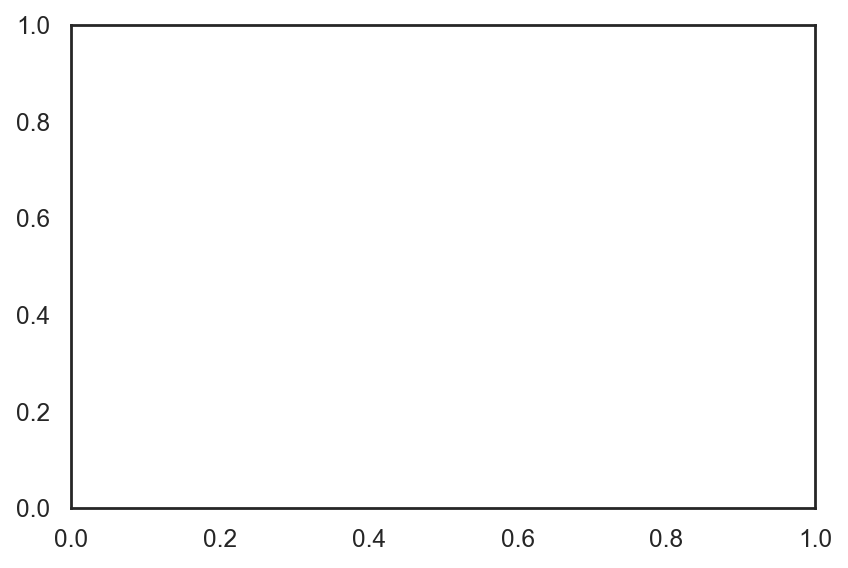

In [122]:
colors = ['#deebf7','#9ecae1','#3182bd']
fig, axes = plt.subplots(figsize=(6, 4))
axs = axes.ravel()
for i,iptg in enumerate(data.IPTG.unique()):
    tmp = data[data.IPTG==iptg]
    def func(x, a, b):
        return (tmp['FITC-A'].max() -tmp['FITC-A'].min()) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + tmp['FITC-A'].min()
    (a_, b_), _ = opt.curve_fit(func, tmp.AHL, tmp['FITC-A'],p0=[1,1e-9],maxfev=10000000)
    n = 1e6
    x = np.linspace(tmp.AHL.min(), tmp.AHL.max(), n)
    print(a_,b_)
    y_fit = func(x, a_, b_)

    
    ax.plot(np.log10(tmp.AHL.values), tmp['FITC-A'].values, 'o',color = colors[i])
    ax.plot(np.log10(x), y_fit, '-',color = colors[i])
plt.show()

In [ ]:
tmp.AHL

In [ ]:
#a, c = np.random.exponential(size=2,scale=1e4)
#b, d = np.random.randn(2)
a,b,c,d = 5000,1000,1e2,1e-5
n = 100
#x = np.linspace(-12, -4, n)
x = np.logspace(-12,-4,n)
y_model = f(x, a, b, c, d)
y = y_model + a * .2 * np.random.randn(n)
#(a_, b_, c_, d_), _ = opt.curve_fit(f, x, y,p0=[1e4,1,1,d])
#y_fit = f(x, a_, b_, c_, d_)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(x, y_model, '--k')
ax.plot(x, y, 'o')
#ax.plot(x, y_fit, '-')
plt.xscale('log')



In [ ]:
print(a_, b_, c_, d_

75632